In [74]:
# download the libraries
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
import numpy as np
from scipy.stats import norm

In [ ]:
from google.colab import files
import pandas as pd

# upload file
uploaded = files.upload()

# get the data
filename = list(uploaded.keys())[0]  # Get uploaded file name
df = pd.read_csv(filename)

In [ ]:
# Transforming the data

df['Price'] = pd.to_numeric(df['Price'].astype(str).str.replace(',', ''), errors='coerce')

# set the date into appropriate format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# get rid of the % sign
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# Sort by date (important for time series plots)
df = df.sort_values('Date')

# calculate squared returns
df["Squared_returns"] = df['Change %'] ** 2

# drop the NaN volume column
df = df.drop("Vol.", axis=1)

In [77]:
# produce summary statistics

def SummaryTable_Columns(data):
  stats = pd.DataFrame(index=data.columns, columns=["Mean", "Variance", "Skewness", "Kurtosis"])
  for column in data.columns:
    # if the column is not numeric then it will be part of the table with nan values
     if pd.to_numeric(data[column], errors='coerce').notnull().all():
        # Calculate Mean
        mean = data[column].mean()

        # Calculate Variance
        variance = data[column].var()

        # Calculate Skewness
        skewness = skew(data[column])

        # Calculate Kurtosis
        kurt = kurtosis(data[column])

        # Store results in the DataFrame
        stats.loc[column] = [mean, variance, skewness, kurt]

  return stats

print(SummaryTable_Columns(df[['Price', 'Change %',"Squared_returns"]]))

                   Mean   Variance Skewness Kurtosis
Price           3599.47 1436526.16     0.51    -0.77
Change %           0.05       1.34    -0.36    14.85
Squared_returns    1.34      30.15    14.90   289.99


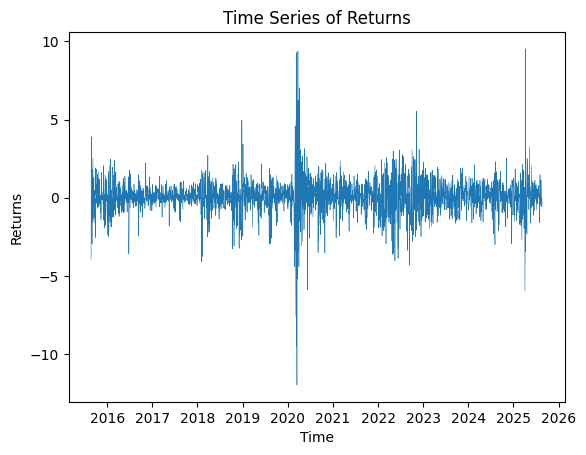

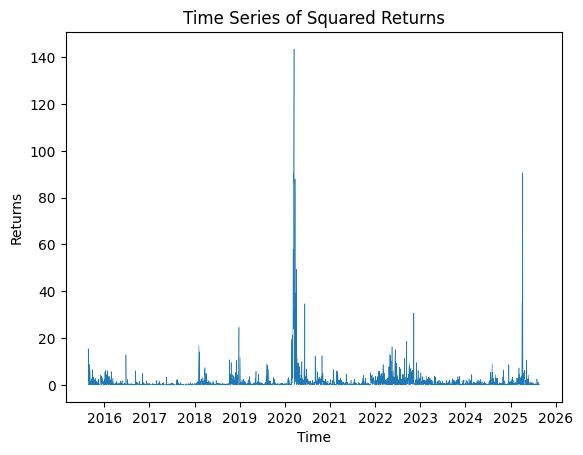

In [78]:
# plot the time series of returns and squared returns
plt.plot(df['Date'], df['Change %'], linewidth=0.4)
plt.xlabel("Time")
plt.ylabel("Returns")
plt.title("Time Series of Returns")
plt.show()

plt.plot(df['Date'], df['Squared_returns'], linewidth=0.4)
plt.xlabel("Time")
plt.ylabel("Returns")
plt.title("Time Series of Squared Returns")
plt.show()

In [79]:
# for GARCH to work returns must be stationary and squared returns must be non-stationary
# we use ADF - Augmented Dickey-Fuller test

result = adfuller(df['Change %'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Now we test the squared returns
result2 = adfuller(df["Squared_returns"].dropna())
print("ADF Statistic:", result2[0])
print("p-value:", result2[1])
print("Critical Values:", result2[4])

# both series are stationary

ADF Statistic: -16.14671651449816
p-value: 4.6149343875250754e-29
Critical Values: {'1%': np.float64(-3.4329642237790847), '5%': np.float64(-2.862694950990622), '10%': np.float64(-2.5673848250020415)}
ADF Statistic: -7.314996393610196
p-value: 1.235933671749332e-10
Critical Values: {'1%': np.float64(-3.4329831717881003), '5%': np.float64(-2.8627033184297384), '10%': np.float64(-2.5673892799386944)}


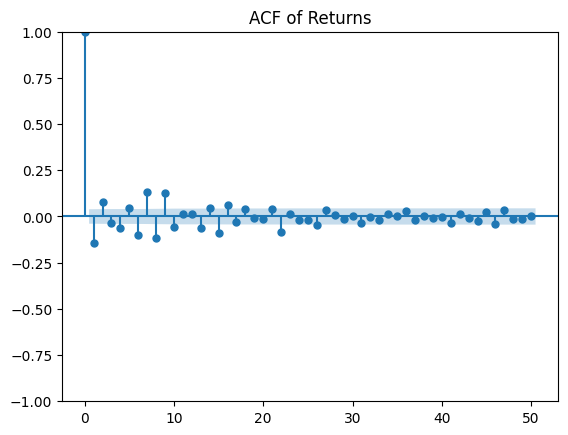

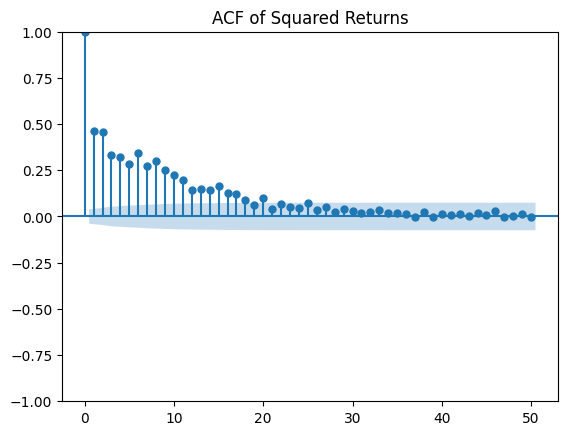

In [80]:
# ACF of returns (should be near zero for lags > 0)
plot_acf(df['Change %'].dropna(), lags=50)
plt.title("ACF of Returns")
plt.show()

# ACF of squared returns (should show persistence if volatility clusters)
plot_acf(df['Squared_returns'].dropna(), lags=50)
plt.title("ACF of Squared Returns")
plt.show()

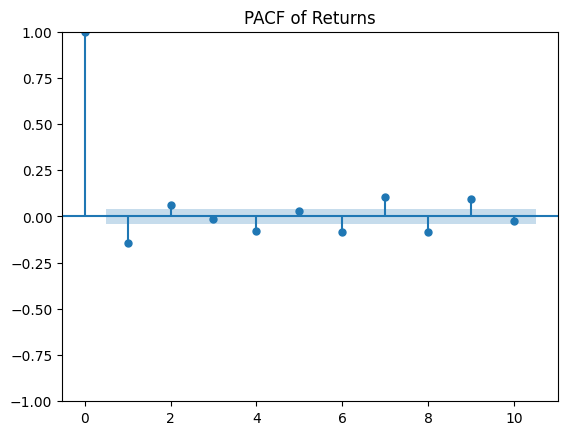

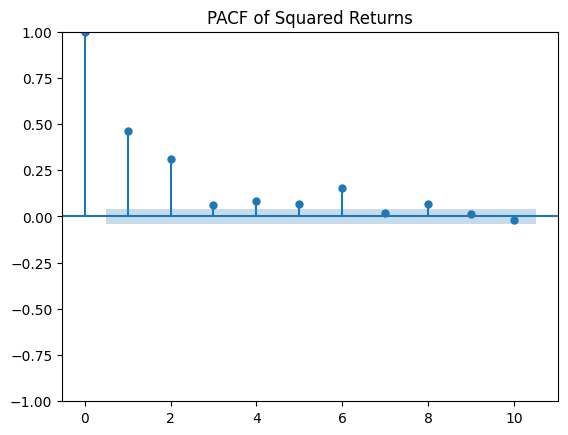

In [81]:
# PACF plot of returns
plot_pacf(df['Change %'].dropna(), lags=10, method="ywm")
plt.title("PACF of Returns")
plt.show()

# PACF plot of squared returns
plot_pacf(df['Squared_returns'].dropna(), lags=10, method="ywm")
plt.title("PACF of Squared Returns")
plt.show()


# Note: 0-th lag will always have ACF and PACF of 1

In [82]:
# GARCH(1,1) with Student-t distribution
am11 = arch_model(df['Change %']
                  , mean='Constant' # constand mean is used as the daily returns are basically a random walk
                  , vol='GARCH', p=1, q=1,
                  dist="t" ) # t-distribution has fatter tails
res_garch = am11.fit()
res_garch.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 22472.948845865038
Iteration:      2,   Func. Count:     19,   Neg. LLF: 13770.830298072986
Iteration:      3,   Func. Count:     29,   Neg. LLF: 43260.920394540546
Iteration:      4,   Func. Count:     36,   Neg. LLF: 3215.8982560183954
Iteration:      5,   Func. Count:     43,   Neg. LLF: 5467.502685750682
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3183.0549154593045
Iteration:      7,   Func. Count:     56,   Neg. LLF: 3184.5493274619093
Iteration:      8,   Func. Count:     63,   Neg. LLF: 3183.929791589853
Iteration:      9,   Func. Count:     70,   Neg. LLF: 3182.952232855483
Iteration:     10,   Func. Count:     76,   Neg. LLF: 3182.9518362350227
Iteration:     11,   Func. Count:     82,   Neg. LLF: 3182.951784482575
Iteration:     12,   Func. Count:     88,   Neg. LLF: 3182.951782069066
Iteration:     13,   Func. Count:     93,   Neg. LLF: 3182.951782069067
Optimization terminated successfully    (Exit mode 0)
   

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                     Change %   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3182.95
Distribution:      Standardized Student's t   AIC:                           6375.90
Method:                  Maximum Likelihood   BIC:                           6405.05
                                              No. Observations:                 2513
Date:                      Sat, Aug 23 2025   Df Residuals:                     2512
Time:                              12:28:29   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0975  1.276e-02      7.638  2.212e-14 [7.247e-02,  0.122]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0196  5.619e-03      3.490  4.838e-04 [8.595e-03,3.062e-02]
alpha[1]       0.1706  2.278e-02      7.489  6.961e-14     [  0.126,  0.215]
beta[1]        0.8272  2.010e-02     41.160      0.000     [  0.788,  0.867]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.4586      0.601      9.079  1.091e-19 [  4.280,  6.637]
========================================================================

Covariance estimator: robust
"""

In [83]:
# Fit EGARCH(1,1) with Student-t distribution
egarch = arch_model(df['Change %'], mean='Constant', vol='EGARCH',
                    p=1, q=1, o=1, dist='t')

res_egarch = egarch.fit(disp='off')
print(res_egarch.summary())

# forecast of variance for the next 1000 days
forecast = res_egarch.forecast(horizon=1000, method="simulation")

# Extract forecasted variance and convert to volatility by taking the square root
vol_forecast = forecast.variance.values[-1] ** 0.5

# take the mean to get estimate of unconditional variance
var_uncond = np.mean(res_egarch.conditional_volatility**2)
print(var_uncond)

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                     Change %   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -3133.87
Distribution:      Standardized Student's t   AIC:                           6279.73
Method:                  Maximum Likelihood   BIC:                           6314.71
                                              No. Observations:                 2513
Date:                      Sat, Aug 23 2025   Df Residuals:                     2512
Time:                              12:28:31   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

In [90]:
# we will define a function for Black-Scholes estimation

def Black_Scholes_df(strikes, yearly_volatility):
    S0 = 6466.91       # Current index level
    T = 5/252          # Time to maturity in years
    r = 0.0426          # Risk-free rate

    sigma = yearly_volatility / 100  # Convert % to decimal

    strikes = np.array(strikes)

    # Black-Scholes formula
    d1 = (np.log(S0 / strikes) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_prices = S0 * norm.cdf(d1) - strikes * np.exp(-r * T) * norm.cdf(d2)

    # Build DataFrame
    df = pd.DataFrame({
        'strike': strikes,
        'Predicted_Call_Price': call_prices
    })

    return df

Black_Scholes_df([5000, 5200], 18)

,strike,Predicted_Call_Price
0,5000,1471.13
1,5200,1271.30


In [91]:
# downlaod option data from Yahoo Finance
import yfinance as yf
ticker = yf.Ticker("^SPX")
print(ticker.options)

('2025-08-25', '2025-08-26', '2025-08-27', '2025-08-28', '2025-08-29', '2025-09-02', '2025-09-03', '2025-09-04', '2025-09-05', '2025-09-08', '2025-09-09', '2025-09-10', '2025-09-11', '2025-09-12', '2025-09-15', '2025-09-16', '2025-09-17', '2025-09-18', '2025-09-19', '2025-09-22', '2025-09-23', '2025-09-26', '2025-09-29', '2025-09-30', '2025-10-03', '2025-10-17', '2025-10-31', '2025-11-21', '2025-11-28', '2025-12-19', '2025-12-31', '2026-01-16', '2026-01-30', '2026-02-20', '2026-03-20', '2026-03-31', '2026-04-17', '2026-05-15', '2026-06-18', '2026-06-30', '2026-07-17', '2026-08-21', '2026-09-18', '2026-12-18', '2027-06-17', '2027-12-17', '2028-12-15', '2029-12-21', '2030-12-20')


In [92]:
# Get the 5th expiration date for 29th of August 2025,
# End of the next trading week
expiry = ticker.options[4]

# Get the option chain for that expiration
opt_chain = ticker.option_chain(expiry)

# Create calls dataframe
calls_df = opt_chain.calls[['strike', 'lastPrice']]

calls_df

,strike,lastPrice
0,1200.00,5252.38
1,1400.00,5058.76
2,1600.00,4855.84
3,1800.00,3636.30
4,2200.00,4247.79
...,...,...
362,7500.00,0.03
363,7600.00,0.05
364,7800.00,0.05
365,8000.00,0.03


In [93]:
# now we compare the actual option prices to our estimates

# round the predicted prices to 2 digits
# this will cause the price of options with extremely high strike price to be 0
# but due to actual price being close to 0, this will not create a lot of troubles
pd.set_option('display.float_format', '{:.2f}'.format)

# we calculate prices for different strike price at 18% annualized volatility
predicted_df = Black_Scholes_df(calls_df['strike'], 18)

#  merge the predicted and actual prices
merged_df = pd.merge(calls_df, predicted_df, on='strike')
merged_df

,strike,lastPrice,Predicted_Call_Price
0,1200.00,5252.38,5267.92
1,1400.00,5058.76,5068.09
2,1600.00,4855.84,4868.26
3,1800.00,3636.30,4668.43
4,2200.00,4247.79,4268.77
...,...,...,...
362,7500.00,0.03,0.00
363,7600.00,0.05,0.00
364,7800.00,0.05,0.00
365,8000.00,0.03,0.00


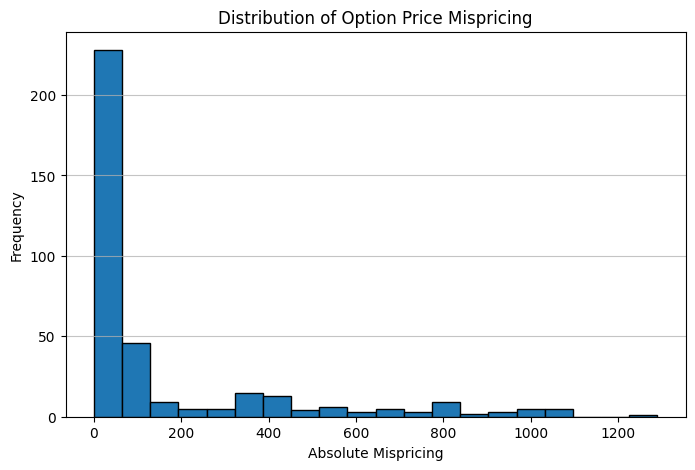

In [94]:
# Finally we take the absolute differences between the prices and plot them
merged_df["absolute mispricing"] = (merged_df['lastPrice'] - merged_df['Predicted_Call_Price']).abs()

# plot the histogram
plt.figure(figsize=(8,5))
plt.hist(merged_df["absolute mispricing"], bins=20, edgecolor='black')
plt.xlabel("Absolute Mispricing")
plt.ylabel("Frequency")
plt.title("Distribution of Option Price Mispricing")
plt.grid(axis='y', alpha=0.75)
plt.show()